In [1]:
import os
import gc
import pdb
import datetime
import cloudpickle

import numpy as np
import scipy as sp
import pandas as pd

import dask.array as da
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client

import lifelines
from joblib import parallel_backend

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import plotly

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
pbar = ProgressBar()
pbar.register()

In [4]:
# inferred int64 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "date": "object",
    "serial_number": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_9_normalized": "float32",
    "smart_9_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_184_normalized": "float32",
    "smart_184_raw": "float32",
    "smart_187_normalized": "float32",
    "smart_187_raw": "float32",
    "smart_188_normalized": "float32",
    "smart_188_raw": "float32",
    "smart_189_normalized": "float32",
    "smart_189_raw": "float32",
    "smart_190_normalized": "float32",
    "smart_190_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_240_normalized": "float32",
    "smart_240_raw": "float32",
    "smart_241_normalized": "float32",
    "smart_241_raw": "float32",
    "smart_242_normalized": "float32",
    "smart_242_raw": "float32"
}

In [5]:
# read all the cleaned seagate data into one dataframe
DATA_DIR = "/home/kachauha/Downloads/data_Q4_2018_seagate_clean"
df = dd.read_csv(os.path.join(DATA_DIR, '*.csv'), dtype=custom_dtypes)

In [6]:
# serial numbers of failed hard drivs
failed_serials = df[df['failure']==1]['serial_number'].compute()

[########################################] | 100% Completed | 15.1s


## Steps

### Without time dependence
1. Collapse across time
2. Use power on hours as the "tenure"/"survival time"
3. Use failure as event occured or not, as well as censorship label

### With time dependence
See [this](https://cran.r-project.org/web/packages/survival/vignettes/timedep.pdf) R paper for details.
1. Treat each day(or week or month) as an interval
2. Every day is a separate observation

## Part 1: Without Time Dependence

### Get covariates, censorship, age

In [29]:
# collapse time dim, drop cols that are unncessary for train data
df_grouped = df.drop(['date', 'failure', 'smart_9_raw', 'smart_9_normalized'], axis=1).groupby('serial_number')

In [30]:
# characterize a time series by simple stats - mean,std,max,min,size,kurtosis
means = df_grouped.mean()
means = means.rename(columns={col: 'mean_' + col for col in means.columns})

stds = df_grouped.std(ddof=0)
stds = stds.rename(columns={col: 'std_' + col for col in stds.columns})
stds = stds.fillna(0)    # FIXME: std returns nans even for ddof=0

# join stats into one df
covars = means.merge(right=stds, left_index=True, right_index=True)
covars.head()

,mean_capacity_bytes,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_184_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_189_raw,mean_smart_190_raw,...,std_smart_188_normalized,std_smart_189_normalized,std_smart_190_normalized,std_smart_193_normalized,std_smart_194_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_240_normalized,std_smart_241_normalized,std_smart_242_normalized
serial_number,,,,,,,,,,,,,,,,,,,,,
6VDHZ9H9,3.200729e+11,1.252961e+08,0.0,3.107040e+08,0.0,0.0,0.0,18.0,0.0,28.478261,...,0.0,0.0,0.714421,0.0,0.714421,0.0,0.0,0.0,0.0,0.0
6VDHZAKY,3.200729e+11,1.346626e+08,0.0,3.117690e+08,0.0,0.0,0.0,19.0,0.0,29.000000,...,0.0,0.0,1.215838,0.0,1.215838,0.0,0.0,0.0,0.0,0.0
6VDHZATY,3.200729e+11,2.070237e+08,0.0,4.240170e+08,0.0,0.0,0.0,8.0,0.0,25.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
6VDHZAXD,3.200729e+11,9.719883e+07,0.0,3.160235e+08,0.0,0.0,0.0,18.0,0.0,28.375000,...,0.0,0.0,1.727534,0.0,1.727534,0.0,0.0,0.0,0.0,0.0
6VDHZB48,3.200729e+11,1.047900e+08,0.0,3.157392e+08,0.0,0.0,0.0,14.0,0.0,30.130435,...,0.0,0.0,1.676029,0.0,1.676029,0.0,0.0,0.0,0.0,0.0


In [31]:
# get the tenure/survival time/lifetime regressor values
df_smart9_grouped = df[['serial_number', 'smart_9_raw', 'smart_9_normalized']].groupby('serial_number')
age = df_smart9_grouped.max()
age.head()

,smart_9_raw,smart_9_normalized
serial_number,,
6VDHZ9H9,41189.0,54.0
6VDHZAKY,41626.0,54.0
6VDHZATY,41530.0,53.0
6VDHZAXD,41438.0,54.0
6VDHZB48,41622.0,54.0


In [32]:
# get the censorship labels
# max in each group (serial_number) will be 1 if the drive had failed or 0 if it has not
censored = df[['serial_number', 'failure']].groupby('serial_number').max()
censored = censored.astype('bool')
censored.head()

,failure
serial_number,
6VDHZ9H9,False
6VDHZAKY,False
6VDHZATY,False
6VDHZAXD,False
6VDHZB48,False


In [33]:
del means
del stds
gc.collect()

12811

### Convert to numpy/pandas in memory

In [34]:
# bring to memory
covars = covars.compute()
age = age.compute()
censored = censored.compute()

In [37]:
pbar.unregister()
del df
gc.collect()

755

### Scale covariates

In [15]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [32]:
# try vanilla standard scaling
std_scaler = StandardScaler()

# scale covariates only
covars_scaled = std_scaler.fit_transform(covars)

# sklearn converts dataframe to numpy - and lifelines needs dataframe
# so convert the output ndarray to df
covars_scaled = pd.DataFrame(covars_scaled,
                            index=covars.index,
                            columns=covars.columns)

### FIXME: scaling covariates causes errors in cox ph model therefore use unscaled version

In [38]:
covars_scaled = covars

### Combine covariates, censor labels, duration labels into one df
This is required by lifelines

In [39]:
# concat, but first drop smart9 norm because the values are not as fine grained as raw values
X_df = pd.concat([covars_scaled, age.drop('smart_9_normalized', axis=1), censored], axis=1)
X_df.head()

,mean_capacity_bytes,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_184_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_189_raw,mean_smart_190_raw,...,std_smart_190_normalized,std_smart_193_normalized,std_smart_194_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_240_normalized,std_smart_241_normalized,std_smart_242_normalized,smart_9_raw,failure
serial_number,,,,,,,,,,,,,,,,,,,,,
6VDHZ9H9,3.200729e+11,1.252961e+08,0.0,3.107040e+08,0.0,0.0,0.0,18.0,0.0,28.478261,...,0.714421,0.0,0.714421,0.0,0.0,0.0,0.0,0.0,41189.0,False
6VDHZAKY,3.200729e+11,1.346626e+08,0.0,3.117690e+08,0.0,0.0,0.0,19.0,0.0,29.000000,...,1.215838,0.0,1.215838,0.0,0.0,0.0,0.0,0.0,41626.0,False
6VDHZATY,3.200729e+11,2.070237e+08,0.0,4.240170e+08,0.0,0.0,0.0,8.0,0.0,25.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,41530.0,False
6VDHZAXD,3.200729e+11,9.719883e+07,0.0,3.160235e+08,0.0,0.0,0.0,18.0,0.0,28.375000,...,1.727534,0.0,1.727534,0.0,0.0,0.0,0.0,0.0,41438.0,False
6VDHZB48,3.200729e+11,1.047900e+08,0.0,3.157392e+08,0.0,0.0,0.0,14.0,0.0,30.130435,...,1.676029,0.0,1.676029,0.0,0.0,0.0,0.0,0.0,41622.0,False


In [40]:
# sanity check - did the merging happen ok
print(covars_scaled.shape)
print(censored.shape)
print(age.shape)
print(X_df.shape)
X_df.isna().any().any()

(82993, 66)
(82993, 1)
(82993, 2)
(82993, 68)


False

In [43]:
# drop cols where variance is below threshold
VAR_THRESHOLD = 0.5

# will have to do this col by col because we dont wanna accidentally drop censor or duration cols
for col in X_df.columns:
    if not (col.startswith('failure') or col.startswith('smart_9')):
        if X_df[col].var() < VAR_THRESHOLD:
            print('Dropping', col)
            X_df.drop(col, axis=1, inplace=True)

In [55]:
# train test split
from sklearn.model_selection import train_test_split

# get the indices for train/test accordinfg to stratification of censor/uncensor
X_train_idx, X_test_idx, _, _ = train_test_split(np.arange(X_df.shape[0]), X_df['failure'], stratify=X_df['failure'])

### Cox PH

In [44]:
from lifelines import CoxPHFitter
from sklearn.metrics import mean_absolute_error, mean_squared_error

Iteration 8: norm_delta = 519.43554, step_size = 0.0000, ll = -2460.17478, newton_decrement = 1337.28190, seconds_since_start = 1.3Convergence failed. See any warning messages.


<lifelines.CoxPHFitter: fitted with 62244 observations, 61988 censored>

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
                                test_statistic      p  -log2(p)
mean_capacity_bytes       km             38.93 <0.005     31.08
                          rank          139.56 <0.005    104.57
mean_smart_10_normalized  km              0.39   0.53      0.91
      

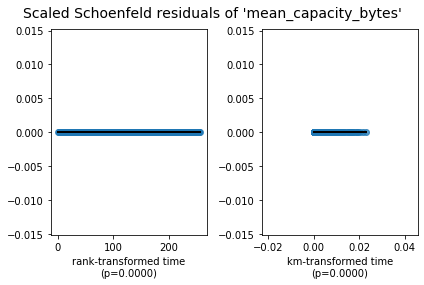

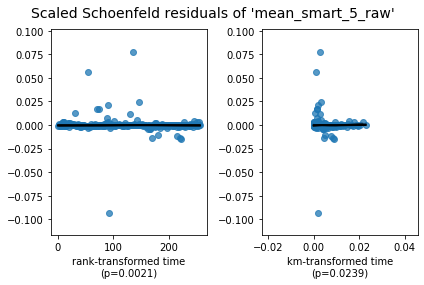

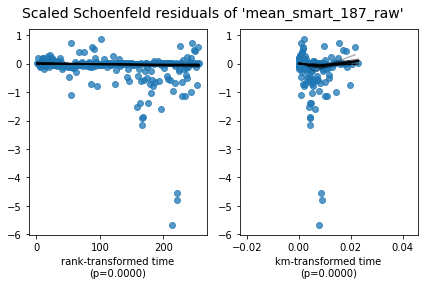

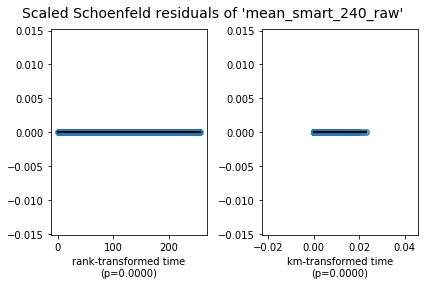

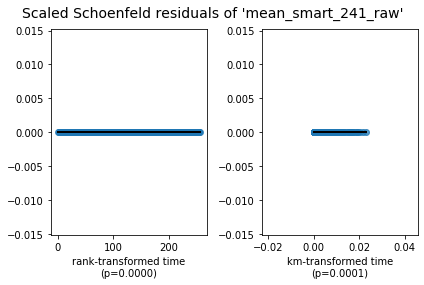

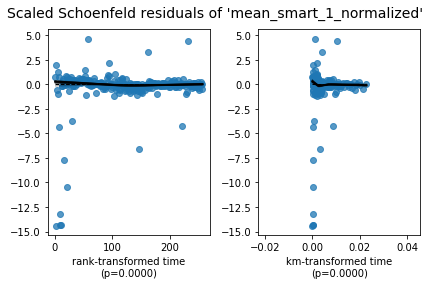

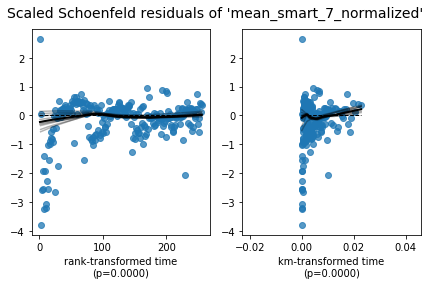

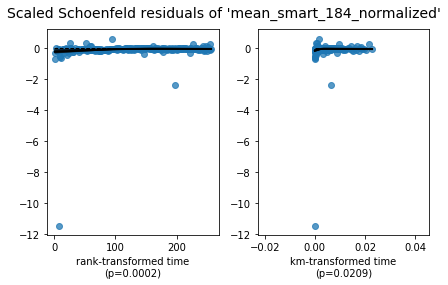

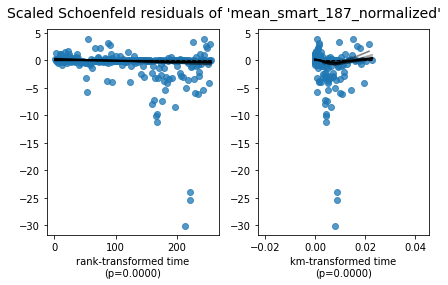

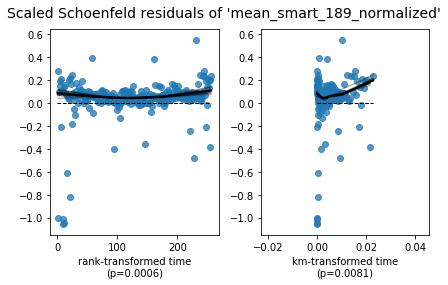

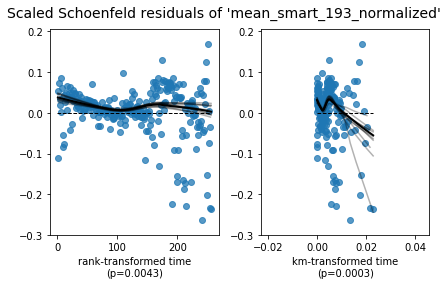

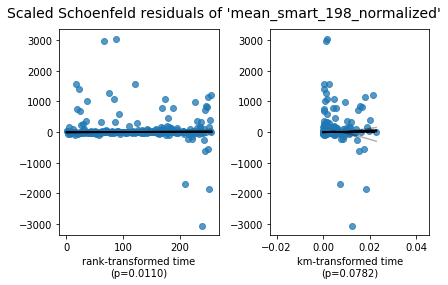

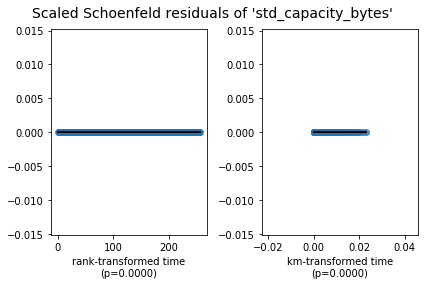

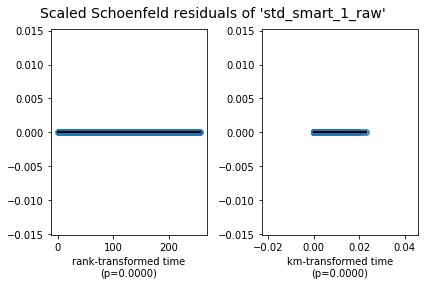

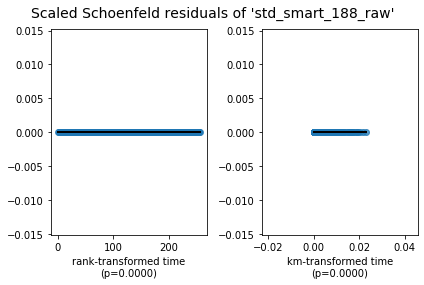

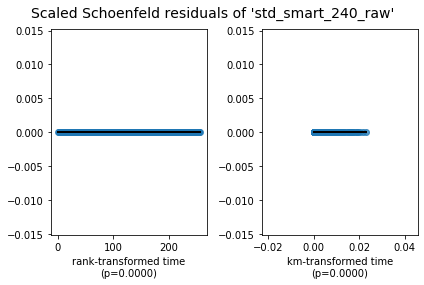

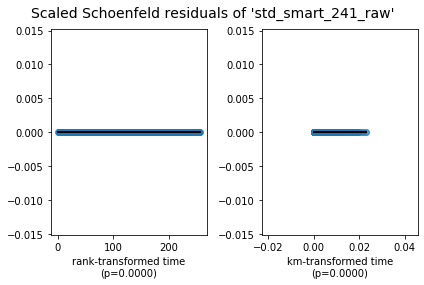

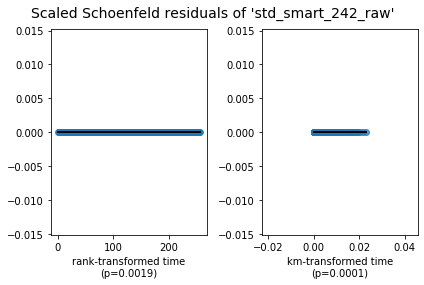

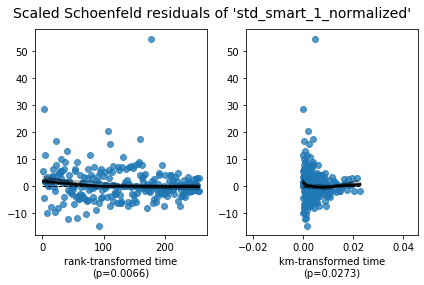

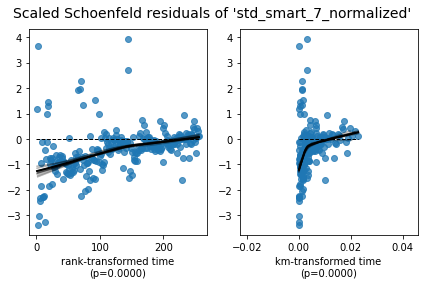

In [65]:
# fit model and check if proportinality assumptions hold true
cph = CoxPHFitter(penalizer=1e-8)
cph.fit(X_df.iloc[X_train_idx, :], 
        duration_col="smart_9_raw", 
        event_col="failure",
        step_size=0.01,
        show_progress=True)
cph.check_assumptions(X_df.iloc[X_train_idx, :], show_plots=True)

In [81]:
# ground truth values of smart 9
true_smart9 = X_df.iloc[X_test_idx, :]

# get labels corresponding to failed drives. this will make evaluation of the coxph model easier
true_smart9_failed = true_smart9[true_smart9['failure']==1]['smart_9_raw']
true_smart9_failed.head()

serial_number
ZCH0D3FM     7057.0
Z305AK1B    23889.0
Z305DGEY    25645.0
ZCH07075     8480.0
Z304KA4N    26513.0
Name: smart_9_raw, dtype: float32

In [73]:
# get the data corresponding to failed drives
X_test_failed = X_df[X_df.index.isin(actual_smart9_failed.index)]
X_test_failed.head()

,mean_capacity_bytes,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_184_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_189_raw,mean_smart_190_raw,mean_smart_193_raw,...,std_smart_193_raw,std_smart_197_raw,std_smart_198_raw,std_smart_240_raw,std_smart_241_raw,std_smart_242_raw,std_smart_1_normalized,std_smart_7_normalized,smart_9_raw,failure
serial_number,,,,,,,,,,,,,,,,,,,,,
S2ZYJ9BF519210,5.001079e+11,4.315789e+01,0.0,0.000000e+00,-100.0,0.070479,8.082069e+07,-100.0,29.177201,19039.113487,...,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,26720.0,True
S2ZYJ9GGB00967,5.001079e+11,5.012500e+01,0.0,0.000000e+00,-100.0,0.070479,8.082069e+07,-100.0,29.177200,19039.112500,...,5.059644,0.156125,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,18867.0,True
S2ZYJ9GGB00982,5.001079e+11,4.940000e+01,0.0,0.000000e+00,-100.0,0.070479,8.082070e+07,-100.0,29.177200,19039.112500,...,7.353040,0.420000,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,17235.0,True
S2ZYJ9KG927405,5.001079e+11,1.903333e+02,0.0,0.000000e+00,-100.0,0.070479,8.082069e+07,-100.0,29.177199,19039.114583,...,0.000000,0.314270,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,21896.0,True
S300WDLE,4.000787e+12,1.059176e+08,0.0,1.104993e+08,0.0,0.000000,0.000000e+00,0.0,20.000000,136930.000000,...,30.169889,0.000000,0.0,19.955506,2.851578e+07,134217728.0,3.399346,0.0,28229.0,True


In [79]:
# measure mae and mse
preds = cph.predict_expectation(X_test_failed)
print('MAE =', mean_absolute_error(X_test_failed['smart_9_raw'], preds))
print('MSE =', mean_squared_error(X_test_failed['smart_9_raw'], preds))

MAE = 30155.660775044107
MSE = 1033888159.4886568


## Part 2: With Time Dependence (interval length = 1 day)

### Extract Subset
Lifelines has no support for dask. Extract a subset of the dataset that will still fit in memory and then train on that. kmeans can be used to extract top k representatives. There are two options for clustering:
1. Remove time dimension, then apply kmeans, then get the serials that are closest points to centers, then from the non-time-collapsed dataset extract all entries corresponding to these serial numbers. 
2. Apply kmeans directly to dataset, select points closest to cluster centers, even if they may belong to the same serial.

We start by using approach 1 in the following cells

In [7]:
# get data for working drives
working_df = df[~df['serial_number'].isin(failed_serials)]

In [8]:
# collapse the time dimension using mean,std,kurt,capacity
working_df_grouped = working_df.drop(['date', 'capacity_bytes', 'failure', 'smart_9_raw', 'smart_9_normalized'], axis=1).groupby('serial_number')

means = working_df_grouped.mean()
means = means.rename(columns={col: 'mean_' + col for col in means.columns})

stds = working_df_grouped.std(ddof=0)
stds = stds.rename(columns={col: 'std_' + col for col in stds.columns})
stds = stds.fillna(0)    # FIXME: std returns nans even for ddof=0

capacities = working_df[['serial_number', 'capacity_bytes']].groupby('serial_number').max()

hours = working_df[['serial_number', 'smart_9_raw', 'smart_9_normalized']].groupby('serial_number').max()

# join stats into one working_df
working_features = means.merge(right=stds, left_index=True, right_index=True)
working_features = working_features.merge(right=hours, left_index=True, right_index=True)
working_features = working_features.merge(right=capacities, left_index=True, right_index=True)
working_features = working_features.compute()
working_features.head()

[########################################] | 100% Completed | 48.9s


,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_184_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_189_raw,mean_smart_190_raw,mean_smart_193_raw,...,std_smart_193_normalized,std_smart_194_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_240_normalized,std_smart_241_normalized,std_smart_242_normalized,smart_9_raw,smart_9_normalized,capacity_bytes
serial_number,,,,,,,,,,,,,,,,,,,,,
6VDHZ9H9,1.252961e+08,0.0,3.107040e+08,0.0,0.0,0.0,18.0,0.0,28.478261,346167.217391,...,0.0,0.714421,0.0,0.0,0.0,0.0,0.0,41189.0,54.0,3.200729e+11
6VDHZAKY,1.346626e+08,0.0,3.117690e+08,0.0,0.0,0.0,19.0,0.0,29.000000,403482.695652,...,0.0,1.215838,0.0,0.0,0.0,0.0,0.0,41626.0,54.0,3.200729e+11
6VDHZATY,2.070237e+08,0.0,4.240170e+08,0.0,0.0,0.0,8.0,0.0,25.000000,348260.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,41530.0,53.0,3.200729e+11
6VDHZAXD,9.719883e+07,0.0,3.160235e+08,0.0,0.0,0.0,18.0,0.0,28.375000,364329.125000,...,0.0,1.727534,0.0,0.0,0.0,0.0,0.0,41438.0,54.0,3.200729e+11
6VDHZB48,1.047900e+08,0.0,3.157392e+08,0.0,0.0,0.0,14.0,0.0,30.130435,409073.782609,...,0.0,1.676029,0.0,0.0,0.0,0.0,0.0,41622.0,54.0,3.200729e+11


In [9]:
del means
del stds
del hours
del capacities
gc.collect()

1127

In [10]:
from sklearn.preprocessing import RobustScaler

from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel, cosine_distances, manhattan_distances

In [11]:
# number of drives to select as the best downsampled set of all working drives
num_working_to_keep = 300

In [12]:
# scale and cluster data via vanilla kmeans
scaler = RobustScaler()
km = KMeans(n_clusters=num_working_to_keep,
            max_iter=1e6,
            n_jobs=-1)
km.fit(scaler.fit_transform(working_features))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000000.0,
       n_clusters=300, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [13]:
# serial numbers that are the best representatives of the working class
working_best_serials = []

# find the serial numbers that were the closest to each cluster center
for i, c in enumerate(km.cluster_centers_):
    
    # all the points that belong to this cluster
    cluster_pts = working_features.iloc[km.labels_==i]
    
    # distance of each point to the center
    min_dist_idx = np.argmin(sp.spatial.distance.cdist(cluster_pts, c.reshape(1, -1), metric='euclidean'))
    working_best_serials.append(cluster_pts.iloc[min_dist_idx].name)

In [38]:
# redefine working df as best representatives from working df
working_df = df[df['serial_number'].isin(working_best_serials)].compute()
working_df.shape

# get failed df as it is
failed_df = df[df['serial_number'].isin(failed_serials)].compute()
failed_df.shape

[########################################] | 100% Completed | 14.9s


(27268, 38)

[########################################] | 100% Completed | 15.2s


(14522, 38)

In [39]:
# combine failed and working data into one df
# NOTE: need to make sure indices are ignored before concatting o/w pandas will complain
X_df = pd.concat([working_df, failed_df], axis=0, ignore_index=True)
X_df.head()

,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
0,2018-10-01,Z4D019KB,6.001175e+12,0.0,115227560.0,0.0,1.935556e+10,30709.0,0.0,0.0,...,100.0,78.0,72.0,2.0,28.0,100.0,100.0,100.0,100.0,100.0
1,2018-10-01,Z4D032PG,6.001175e+12,0.0,118170800.0,0.0,6.201160e+10,30696.0,0.0,0.0,...,100.0,82.0,73.0,48.0,27.0,100.0,100.0,100.0,100.0,100.0
2,2018-10-01,Z4D04BDA,6.001175e+12,0.0,63432688.0,0.0,4.048924e+10,30721.0,0.0,0.0,...,100.0,1.0,75.0,53.0,25.0,100.0,100.0,100.0,100.0,100.0
3,2018-10-01,ZA12WYY1,8.001563e+12,0.0,227883360.0,0.0,3.891056e+09,16116.0,0.0,0.0,...,100.0,100.0,68.0,92.0,32.0,100.0,100.0,100.0,100.0,100.0
4,2018-10-01,Z4D05J4J,6.001175e+12,0.0,73360216.0,0.0,1.975821e+09,30709.0,0.0,0.0,...,100.0,78.0,77.0,1.0,23.0,100.0,100.0,100.0,100.0,100.0


In [40]:
# these are massive redundant chunks
del working_df
del failed_df
gc.collect()

3241

### Add Start and End columns
This is required by the lifelines library.
**NOTE**: This method also works with dask. So in the future if there's a library that supports dask, the following cells can still be used.

In [41]:
def get_start_timedelta(group):
    return group.assign(start=group['date']-group['date'].min())

In [42]:
# convert from str to datetime
X_df['date'] = X_df['date'].astype('datetime64')

# # create meta of the resulting X_df otherwise dask complains
# start_meta = X_df._meta
# start_meta = start_meta.assign(start=start_meta['date']-start_meta['date'].min())

# get start date as 0 for the first day and 1, 2, 3... for the next. result will be multiindexed so reset index
X_df = X_df.groupby('serial_number').apply(get_start_timedelta).reset_index(drop=True)

# add the end day as one more than start day
X_df['end'] = X_df['start'] + np.timedelta64(1, 'D')

### Preprocess

In [43]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [45]:
# get the features, not the labels
feat_cols = X_df.columns.drop(['date', 'serial_number', 'failure', 'start', 'end'])
feats = X_df[feat_cols]

# scale only the features
scaler = StandardScaler()
feats = pd.DataFrame(scaler.fit_transform(feats),
                     index=feats.index,
                     columns=feats.columns)

In [46]:
# combine scaled featuers and lavels
X_df_scaled = pd.concat([feats, X_df[['serial_number', 'failure', 'start', 'end']]], axis=1)
X_df_scaled.head()
X_df_scaled.shape

,capacity_bytes,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,smart_187_raw,smart_188_raw,smart_189_raw,...,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized,serial_number,failure,start,end
0,-2.620591,-0.942580,-0.090425,-0.088408,1.696228,0.0,0.412955,-0.082295,-0.090916,-0.05374,...,0.003644,-0.109707,-0.114307,-8.299575,-8.299575,-8.299575,S2X67QW1,0.0,0 days,1 days
1,-2.620591,-0.844767,-0.090425,-0.088408,1.698560,0.0,0.412955,-0.082295,-0.090916,-0.05374,...,0.003644,-0.109707,-0.114307,-8.299575,-8.299575,-8.299575,S2X67QW1,0.0,1 days,2 days
2,-2.620591,-0.735639,-0.090425,-0.088408,1.701086,0.0,0.412955,-0.082295,-0.090916,-0.05374,...,0.003644,-0.109707,-0.114307,-8.299575,-8.299575,-8.299575,S2X67QW1,0.0,2 days,3 days
3,-2.620591,-0.638925,-0.090425,-0.088408,1.703418,0.0,0.412955,-0.082295,-0.090916,-0.05374,...,-0.150352,-0.109707,-0.114307,-8.299575,-8.299575,-8.299575,S2X67QW1,0.0,3 days,4 days
4,-2.620591,-0.518681,-0.090425,-0.088407,1.705750,0.0,0.412955,-0.082295,-0.090916,-0.05374,...,0.157641,-0.109707,-0.114307,-8.299575,-8.299575,-8.299575,S2X67QW1,0.0,4 days,5 days


(41790, 39)

In [47]:
del feats
gc.collect()

2681

### Apply Time Varying Cox PH model
**NOTE**: Some changes are cumulative, vs some changes are status updates

In [48]:
from lifelines import CoxTimeVaryingFitter

In [49]:
# adjust to how lifelines wants it
X_df_scaled['start'] = X_df_scaled['start'].astype(np.int64)
X_df_scaled['end'] = X_df_scaled['end'].astype(np.int64)
X_df_scaled['failure'] = X_df_scaled['failure'].astype(np.bool)

In [67]:
# these cols have high corr. this causes problems with lifelines
drop_cols = ['smart_240_normalized', 
             'smart_241_normalized', 
             'smart_242_normalized', 
             'smart_194_normalized', 
             'smart_197_normalized',
             'smart_5_normalized',
             'smart_7_normalized',
             'smart_10_normalized',
             'smart_198_normalized']

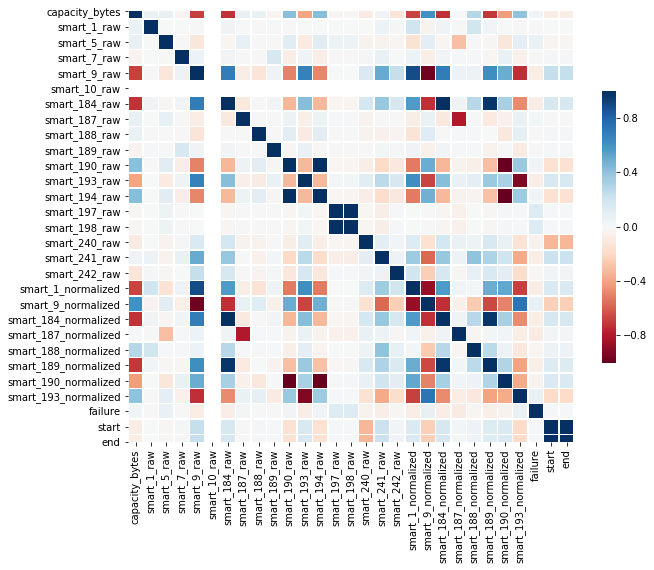

In [68]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X_df_scaled.drop(drop_cols, axis=1).corr(),
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

In [69]:
# FIXME: lifelines has no support for dask - find a lib w/ dask support OR
# find a way of doing gradient descent in lifeline in batches and use dd partitions
ctv = CoxTimeVaryingFitter(penalizer=1e-2)
ctv.fit(X_df_scaled.drop(drop_cols, axis=1),
        id_col="serial_number", 
        event_col="failure", 
        start_col="start",
        stop_col="end",
        step_size=1e-4,
        show_progress=True)

ConvergenceError: hessian or gradient contains nan or inf value(s). Convergence halted. Please see the following tips in the lifelines documentation:
https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
array must not contain infs or NaNs

## Part 3: Deep Survival Analysis